In [84]:
#The implemetation of k-anonymity, l-diversity, and t-closeness has been used from the codes provided in 
# https://github.com/Nuclearstar/K-Anonymity

# Import dataset

In [ ]:
import pandas as pd
import numpy as np

In [85]:
# this is a list of the column names in our dataset (as the file doesn't contain any headers)
names = (
    'A1', 'A2',    'A3',  'A4',   'A5',  'A6',  'A7',  'A8', 'A9', 'A10', 'A11',
    'A12', 'A13',  'A14', 'A15', 'A16', 'A17',  'A18', 'A19',  'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27',
    'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39',
    'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',  'A52', 'A53', 'A54', 'A55', 'A56', 'A57',
    'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64',
    'class',
    )

# some fields are categorical and will require special treatment
categorical = set((
    'class',
))
df = pd.read_csv("optdigits.txt", sep=",", header=None, names=names, index_col=False, engine='python');# We load the data using Pandas

In [86]:
df.shape

(3823, 65)

In [87]:
np.unique(df['class'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([376, 389, 380, 389, 387, 376, 377, 387, 380, 382], dtype=int64))

In [6]:
df.dtypes

A1       int64
A2       int64
A3       int64
A4       int64
A5       int64
         ...  
A61      int64
A62      int64
A63      int64
A64      int64
class    int64
Length: 65, dtype: object

In [8]:
for name in categorical:
    df[name] = df[name].astype('category')

# k-anonymity

In [9]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [10]:
full_spans = get_spans(df, df.index)
full_spans

{'A1': 0,
 'A2': 8,
 'A3': 16,
 'A4': 16,
 'A5': 16,
 'A6': 16,
 'A7': 16,
 'A8': 16,
 'A9': 5,
 'A10': 15,
 'A11': 16,
 'A12': 16,
 'A13': 16,
 'A14': 16,
 'A15': 16,
 'A16': 15,
 'A17': 5,
 'A18': 16,
 'A19': 16,
 'A20': 16,
 'A21': 16,
 'A22': 16,
 'A23': 16,
 'A24': 8,
 'A25': 1,
 'A26': 16,
 'A27': 16,
 'A28': 16,
 'A29': 16,
 'A30': 16,
 'A31': 16,
 'A32': 2,
 'A33': 1,
 'A34': 15,
 'A35': 16,
 'A36': 16,
 'A37': 16,
 'A38': 16,
 'A39': 14,
 'A40': 0,
 'A41': 7,
 'A42': 16,
 'A43': 16,
 'A44': 16,
 'A45': 16,
 'A46': 16,
 'A47': 16,
 'A48': 6,
 'A49': 10,
 'A50': 16,
 'A51': 16,
 'A52': 16,
 'A53': 16,
 'A54': 16,
 'A55': 16,
 'A56': 12,
 'A57': 1,
 'A58': 10,
 'A59': 16,
 'A60': 16,
 'A61': 16,
 'A62': 16,
 'A63': 16,
 'A64': 16,
 'class': 10}

In [11]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [17]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [18]:
# we apply our partitioning method to two columns of our dataset, using "income" as the sensitive attribute
feature_columns = [ 'A2',    'A3',  'A4',   'A5',  'A6',  'A7',  'A8', 'A9', 'A10', 'A11',
    'A12', 'A13',  'A14', 'A15', 'A16', 'A17',  'A18', 'A19',  'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27',
    'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',  'A52', 'A53', 'A54', 'A55', 'A56', 'A57',
    'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64']      
sensitive_column = 'class'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [19]:
# we get the number of partitions that were created
len(finished_partitions)

1027

In [20]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [21]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [22]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [23]:
# let's see how our rects look like
rects[:10]

[((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0)),
 ((0.0, 0.0), (1.0, 1.0))]

In [24]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

In [25]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [26]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [27]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...
Finished 901 partitions...
Finished 1001 partitions...


In [28]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,...,A57,A58,A59,A60,A61,A62,A63,A64,class,count
263,0.000000,0.000000,0.000000,2.666667,13.666667,3.333333,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,3.000000,14.333333,3.666667,0.000000,1,3
264,0.000000,0.000000,0.000000,4.000000,14.000000,3.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.666667,1.333333,0.000000,4.666667,15.666667,2.000000,0.000000,1,3
1539,0.000000,0.000000,0.000000,4.666667,15.333333,3.666667,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,6.666667,14.333333,0.000000,0.000000,1,3
266,0.000000,0.000000,0.000000,7.000000,15.000000,4.666667,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,8.000000,15.666667,3.333333,0.000000,1,3
39,0.000000,0.000000,0.000000,7.600000,11.000000,0.200000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,7.400000,10.800000,0.400000,0.000000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,3.666667,14.000000,16.000000,12.000000,0.666667,0.000000,0.0,0.0,8.666667,13.666667,...,0.0,3.000000,14.000000,14.666667,14.666667,14.666667,13.000000,0.333333,2,3
1500,4.000000,12.666667,15.666667,16.000000,10.333333,0.000000,0.0,0.0,4.333333,9.666667,...,0.0,1.666667,14.666667,13.333333,8.333333,2.000000,0.000000,0.000000,3,3
1854,4.000000,14.000000,16.000000,16.000000,14.333333,2.333333,0.0,0.0,4.666667,11.333333,...,0.0,3.666667,13.666667,10.666667,9.333333,4.333333,0.000000,0.000000,3,2
1855,4.000000,14.000000,16.000000,16.000000,14.333333,2.333333,0.0,0.0,4.666667,11.333333,...,0.0,3.666667,13.666667,10.666667,9.333333,4.333333,0.000000,0.000000,7,1


In [29]:
dfnc = dfn
dfnc['class'] =dfnc['class'].astype(str).astype(int)

In [30]:
import numpy as np
dfn3= np.repeat(dfnc.values, dfnc['count'].values, axis=0)

In [31]:
dfn2 = pd.DataFrame(np.repeat(dfnc.values, dfnc['count'].values, axis=0), columns=[
    'A2',    'A3',  'A4',   'A5',  'A6',  'A7',  'A8', 'A9', 'A10', 'A11',
    'A12', 'A13',  'A14', 'A15', 'A16', 'A17',  'A18', 'A19',  'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27',
    'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',  'A52', 'A53', 'A54', 'A55', 'A56', 'A57',
    'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'class', 'count'])

In [32]:
dfn1=dfn2.drop(columns=['count'])

# L-diversity

In [33]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(df, partition, sensitive_column) >= l

In [34]:
# now let's apply this method to our data and see how the result changes
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [35]:

len(finished_l_diverse_partitions)

826

In [36]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [37]:
# again we build an anonymized dataset from the l-diverse partitions
dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...
Finished 601 partitions...
Finished 701 partitions...
Finished 801 partitions...


In [38]:
# Let's see how l-diversity improves the anonymity of our dataset
dfl.sort_values([column_x, column_y, sensitive_column])

,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,...,A57,A58,A59,A60,A61,A62,A63,A64,class,count
22,0.000000,0.00,3.000000,14.800000,4.600000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,3.000000,15.000000,9.600000,1.800000,0.0,0,1
65,0.000000,0.00,9.166667,10.833333,0.500000,0.000000,0.0,0.0,0.000000,4.666667,...,0.0,0.0,0.000000,11.333333,9.333333,1.500000,0.166667,0.0,0,1
411,0.000000,0.00,7.000000,9.000000,1.000000,0.000000,0.0,0.0,0.000000,0.750000,...,0.0,0.0,0.000000,9.000000,9.250000,1.250000,0.000000,0.0,0,1
423,0.000000,0.00,8.250000,10.750000,0.500000,0.000000,0.0,0.0,0.250000,6.000000,...,0.0,0.0,0.000000,8.500000,13.000000,4.000000,0.000000,0.0,0,1
501,0.000000,0.00,7.833333,14.333333,1.000000,0.666667,0.0,0.0,0.000000,3.166667,...,0.0,0.0,0.000000,9.833333,11.500000,1.666667,0.000000,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,3.000000,13.25,15.500000,10.250000,3.000000,0.000000,0.0,0.0,5.750000,15.500000,...,0.0,2.5,12.500000,16.000000,14.250000,7.250000,1.000000,0.0,2,1
1415,3.000000,13.25,15.500000,10.250000,3.000000,0.000000,0.0,0.0,5.750000,15.500000,...,0.0,2.5,12.500000,16.000000,14.250000,7.250000,1.000000,0.0,3,2
1416,3.000000,13.25,15.500000,10.250000,3.000000,0.000000,0.0,0.0,5.750000,15.500000,...,0.0,2.5,12.500000,16.000000,14.250000,7.250000,1.000000,0.0,8,1
1841,6.333333,16.00,16.000000,16.000000,15.666667,4.666667,0.0,0.0,3.666667,11.666667,...,0.0,5.0,14.333333,9.000000,5.333333,2.666667,0.000000,0.0,3,1


In [39]:
dflc = dfl
dflc['class'] =dflc['class'].astype(str).astype(int)

In [40]:
import numpy as np
dfl3= np.repeat(dflc.values, dflc['count'].values, axis=0)

In [41]:
dfl2 = pd.DataFrame(np.repeat(dflc.values, dflc['count'].values, axis=0), columns=[
     'A2',    'A3',  'A4',   'A5',  'A6',  'A7',  'A8', 'A9', 'A10', 'A11',
    'A12', 'A13',  'A14', 'A15', 'A16', 'A17',  'A18', 'A19',  'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27',
    'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',  'A52', 'A53', 'A54', 'A55', 'A56', 'A57',
    'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'class', 'count'])

In [42]:
dfl1=dfl2.drop(columns=['count'])

# t-closeness

In [43]:
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [44]:
global_freqs

{0: 0.09835207951870259,
 1: 0.10175255035312582,
 2: 0.09939837823698666,
 3: 0.10175255035312582,
 4: 0.10122940099398378,
 5: 0.09835207951870259,
 6: 0.0986136541982736,
 7: 0.10122940099398378,
 8: 0.09939837823698666,
 9: 0.0999215275961287}

In [45]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [46]:
#df = df.astype({"Age":object, "scaling": })

In [47]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [48]:
len(finished_t_close_partitions)

64

In [49]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [50]:
# Let's see how t-closeness fares
dft.sort_values([column_x, column_y, sensitive_column])

,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,...,A57,A58,A59,A60,A61,A62,A63,A64,class,count
395,0.000000,0.500000,7.250000,14.000000,8.750000,0.000000,0.000000,0.0,1.000000,4.500000,...,0.0,0.000000,0.500000,6.250000,13.000000,8.500000,1.500000,0.000000,1,1
396,0.000000,0.500000,7.250000,14.000000,8.750000,0.000000,0.000000,0.0,1.000000,4.500000,...,0.0,0.000000,0.500000,6.250000,13.000000,8.500000,1.500000,0.000000,4,1
397,0.000000,0.500000,7.250000,14.000000,8.750000,0.000000,0.000000,0.0,1.000000,4.500000,...,0.0,0.000000,0.500000,6.250000,13.000000,8.500000,1.500000,0.000000,8,1
398,0.000000,0.500000,7.250000,14.000000,8.750000,0.000000,0.000000,0.0,1.000000,4.500000,...,0.0,0.000000,0.500000,6.250000,13.000000,8.500000,1.500000,0.000000,9,1
295,0.000000,0.666667,9.083333,14.916667,9.375000,2.125000,0.000000,0.0,0.333333,7.333333,...,0.0,0.000000,0.833333,9.791667,13.208333,5.458333,0.500000,0.000000,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1.113043,11.426087,16.000000,12.434783,5.286957,0.765217,0.052174,0.0,5.121739,14.617391,...,0.0,1.008696,11.747826,14.313043,11.426087,7.478261,3.478261,0.513043,9,7
374,1.142857,12.142857,9.285714,2.571429,3.571429,6.142857,1.428571,0.0,4.714286,14.857143,...,0.0,1.857143,12.857143,9.142857,4.857143,2.857143,2.571429,0.285714,2,2
375,1.142857,12.142857,9.285714,2.571429,3.571429,6.142857,1.428571,0.0,4.714286,14.857143,...,0.0,1.857143,12.857143,9.142857,4.857143,2.857143,2.571429,0.285714,3,1
376,1.142857,12.142857,9.285714,2.571429,3.571429,6.142857,1.428571,0.0,4.714286,14.857143,...,0.0,1.857143,12.857143,9.142857,4.857143,2.857143,2.571429,0.285714,4,2


In [51]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [52]:
dftc = dft
dftc['class'] =dftc['class'].astype(str).astype(int)

In [53]:
import numpy as np
dft3= np.repeat(dftc.values, dftc['count'].values, axis=0)

In [54]:
dft2 = pd.DataFrame(np.repeat(dftc.values, dftc['count'].values, axis=0), columns=[ 'A2',    'A3',  'A4',   'A5',  'A6',  'A7',  'A8', 'A9', 'A10', 'A11',
    'A12', 'A13',  'A14', 'A15', 'A16', 'A17',  'A18', 'A19',  'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27',
    'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A50', 'A51',  'A52', 'A53', 'A54', 'A55', 'A56', 'A57',
    'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'A64', 'class', 'count'])

In [55]:
dft1=dft2.drop(columns=['count'])

# Naive Bayes

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
#from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import make_classification
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [57]:
#x = dfn.drop(['workclass',  'education', 'marital-status', 'occupation',    'relationship', 'sex','native-country', 'race', 'income'], axis=1)
# x= df
x = df.drop(columns=['class'])
y = df['class']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

In [58]:
gnb = GaussianNB()

In [59]:
y_pred = gnb.fit(x_train, y_train).predict(x_test)

In [60]:
accuracy_nb = accuracy_score(y_test, y_pred)*100
accuracy_nb

81.58995815899581

In [61]:
scores_nb = cross_val_score(gnb, x, y, cv=5)
scores_nb.mean()

0.7925842577394736

In [62]:
f1_nb = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_nb= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_nb= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_nb = roc_auc_score(y_test, y_pred)

In [63]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97        86
           1       0.82      0.74      0.78        98
           2       0.91      0.91      0.91       100
           3       0.86      0.85      0.86       108
           4       0.98      0.57      0.72        81
           5       1.00      0.53      0.69        94
           6       0.89      0.99      0.94        93
           7       0.83      0.93      0.88       118
           8       0.47      0.94      0.62        81
           9       0.88      0.67      0.76        97

    accuracy                           0.82       956
   macro avg       0.86      0.81      0.81       956
weighted avg       0.86      0.82      0.82       956



# Decision Tree

In [64]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier()
clftree.fit(x_train,y_train)
y_pred = clftree.predict(x_test)
accuracy_dt = accuracy_score(y_test, y_pred)*100
accuracy_dt

90.27196652719665

In [65]:
scores_dt = cross_val_score(clftree, x, y, cv=5)
scores_dt.mean()

0.8974628463411249

In [66]:
f1_dt = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_dt= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_dt= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_dt = roc_auc_score(y_test, y_pred)

In [67]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        86
           1       0.89      0.89      0.89        98
           2       0.91      0.91      0.91       100
           3       0.93      0.83      0.88       108
           4       0.86      0.91      0.89        81
           5       0.94      0.94      0.94        94
           6       0.97      0.96      0.96        93
           7       0.93      0.92      0.92       118
           8       0.89      0.81      0.85        81
           9       0.78      0.89      0.83        97

    accuracy                           0.90       956
   macro avg       0.90      0.90      0.90       956
weighted avg       0.90      0.90      0.90       956



# KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
#cm = confusion_matrix(y_test,y_pred)

In [70]:
accuracy_knn = accuracy_score(y_test, y_pred)*100
accuracy_knn

98.01255230125523

In [71]:
scores_knn = cross_val_score(knn, x, y, cv=5)
scores_knn.mean()

0.9822123386818582

In [72]:
f1_knn = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_knn= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_knn= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_knn = roc_auc_score(y_test, y_pred)

In [73]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.93      1.00      0.97        98
           2       0.99      0.98      0.98       100
           3       0.97      0.97      0.97       108
           4       0.99      1.00      0.99        81
           5       0.98      0.99      0.98        94
           6       0.99      0.99      0.99        93
           7       0.98      0.97      0.98       118
           8       1.00      0.94      0.97        81
           9       0.98      0.96      0.97        97

    accuracy                           0.98       956
   macro avg       0.98      0.98      0.98       956
weighted avg       0.98      0.98      0.98       956



# SVM

In [74]:
#rbf kernel
from sklearn import svm
rbfsvm = svm.SVC(kernel = "rbf")
rbfsvm.fit(x_train,y_train)
y_pred = rbfsvm.predict(x_test)

C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [75]:
accuracy_svm = accuracy_score(y_test, y_pred)*100
accuracy_svm

50.73221757322176

In [76]:
scores_svm = cross_val_score(rbfsvm, x, y, cv=5)
scores_svm.mean()

C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning

0.6654901584534038

In [77]:
f1_svm = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_svm= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_svm= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_svm = roc_auc_score(y_test, y_pred)

In [78]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71        86
           1       1.00      0.53      0.69        98
           2       1.00      0.45      0.62       100
           3       1.00      0.46      0.63       108
           4       0.98      0.73      0.84        81
           5       1.00      0.30      0.46        94
           6       1.00      0.63      0.78        93
           7       1.00      0.25      0.41       118
           8       0.15      1.00      0.26        81
           9       1.00      0.35      0.52        97

    accuracy                           0.51       956
   macro avg       0.91      0.53      0.59       956
weighted avg       0.93      0.51      0.59       956



# Random Forest

In [79]:
from sklearn.ensemble import RandomForestClassifier
rftree=RandomForestClassifier(n_estimators=100)
rftree.fit(x_train,y_train)
y_pred = rftree.predict(x_test)

In [80]:
accuracy_rf = accuracy_score(y_test, y_pred)*100
accuracy_rf

97.90794979079497

In [81]:
scores_rf = cross_val_score(rftree, x, y, cv=5)
scores_rf.mean()

0.9782988972277146

In [83]:
f1_rf = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_rf= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_rf= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_rf = roc_auc_score(y_test, y_pred)

In [84]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.98      0.98      0.98        98
           2       0.99      0.98      0.98       100
           3       0.98      0.96      0.97       108
           4       0.98      1.00      0.99        81
           5       0.97      0.99      0.98        94
           6       0.98      0.99      0.98        93
           7       0.97      0.97      0.97       118
           8       0.98      0.98      0.98        81
           9       0.97      0.95      0.96        97

    accuracy                           0.98       956
   macro avg       0.98      0.98      0.98       956
weighted avg       0.98      0.98      0.98       956



# Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logReg = LogisticRegression()
logReg.fit(x_train,y_train)
y_pred = logReg.predict(x_test)

C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [86]:
accuracy_lr = accuracy_score(y_test, y_pred)*100
accuracy_lr

96.54811715481172

In [87]:
scores_lr = cross_val_score(logReg, x, y, cv=5)
scores_lr.mean()

C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning

0.9613004468442983

In [89]:
f1_lr= round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_lr= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_lr= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_lr = roc_auc_score(y_test, y_pred)

In [90]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        86
           1       0.94      0.94      0.94        98
           2       0.98      0.98      0.98       100
           3       0.98      0.95      0.97       108
           4       0.96      0.96      0.96        81
           5       0.94      1.00      0.97        94
           6       0.98      0.98      0.98        93
           7       1.00      0.99      1.00       118
           8       0.93      0.94      0.93        81
           9       0.94      0.92      0.93        97

    accuracy                           0.97       956
   macro avg       0.96      0.96      0.96       956
weighted avg       0.97      0.97      0.97       956



# AdaBoost

In [91]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
adaboost= AdaBoostClassifier()
adaboost.fit(x_train,y_train)
y_pred = adaboost.predict(x_test)
accuracy_ab = accuracy_score(y_test, y_pred)*100
accuracy_ab

27.615062761506277

In [92]:
scores_ab = cross_val_score(adaboost, x, y, cv=5)
scores_ab.mean()

0.545566419538017

In [93]:
f1_ab = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_ab= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_ab= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_ab = roc_auc_score(y_test, y_pred)

C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.93      0.81        86
           1       0.44      0.11      0.18        98
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00       108
           4       0.00      0.00      0.00        81
           5       0.50      0.07      0.13        94
           6       0.36      0.96      0.53        93
           7       0.00      0.00      0.00       118
           8       0.14      0.94      0.24        81
           9       0.25      0.01      0.02        97

    accuracy                           0.28       956
   macro avg       0.24      0.30      0.19       956
weighted avg       0.23      0.28      0.18       956



C:\Users\20184069\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Bagging

In [95]:
from sklearn.ensemble.bagging import BaggingClassifier
bg = BaggingClassifier()
bg.fit(x_train,y_train)
y_pred = bg.predict(x_test)
accuracy_bg = accuracy_score(y_test, y_pred)*100
accuracy_bg

96.33891213389121

In [96]:
scores_bg = cross_val_score(bg, x, y, cv=5)
scores_bg.mean()

0.9550108142119672

In [97]:
f1_bg = round(f1_score(y_test, y_pred, average="weighted")*100, 2)
p_bg= round(precision_score(y_test, y_pred, average="weighted")*100, 2)
r_bg= round(recall_score(y_test, y_pred, average="weighted")*100, 2)
#auc_bg = roc_auc_score(y_test, y_pred)

In [98]:
import sklearn
from sklearn.metrics import classification_report
print (sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        86
           1       0.94      1.00      0.97        98
           2       0.98      0.95      0.96       100
           3       0.94      0.94      0.94       108
           4       0.95      0.99      0.97        81
           5       1.00      0.97      0.98        94
           6       0.99      0.99      0.99        93
           7       0.98      0.94      0.96       118
           8       0.93      0.91      0.92        81
           9       0.94      0.95      0.94        97

    accuracy                           0.96       956
   macro avg       0.96      0.96      0.96       956
weighted avg       0.96      0.96      0.96       956



In [99]:
c2= ( round(accuracy_dt,2), round(accuracy_nb,2), round(accuracy_knn,2), round(accuracy_svm, 2), round(accuracy_rf, 2), round(accuracy_lr,2),  round(accuracy_ab, 2), round(accuracy_bg,2))
c2

(90.27, 81.59, 98.01, 50.73, 97.91, 96.55, 27.62, 96.34)

In [100]:
cc =( round(scores_dt.mean()*100, 2), round(scores_nb.mean()*100,2 ), round(scores_knn.mean()*100,2), round(scores_svm.mean()*100, 2), round(scores_rf.mean()*100, 2), round(scores_lr.mean()*100, 2),   round(scores_ab.mean()*100, 2), round(scores_bg.mean()*100,2)  )
cc

(89.75, 79.26, 98.22, 66.55, 97.83, 96.13, 54.56, 95.5)

In [101]:
f1 = (f1_dt, f1_nb , f1_knn, f1_svm, f1_rf , f1_lr , f1_ab , f1_bg )
f1

(90.29, 81.74, 98.01, 58.71, 97.9, 96.55, 17.72, 96.34)

In [102]:
p = (p_dt, p_nb , p_knn, p_svm, p_rf , p_lr , p_ab , p_bg )
p

(90.48, 86.02, 98.06, 92.63, 97.91, 96.57, 23.08, 96.38)

In [103]:
r = (r_dt, r_nb , r_knn, r_svm, r_rf , r_lr , r_ab , r_bg )
r

(90.27, 81.59, 98.01, 50.73, 97.91, 96.55, 27.62, 96.34)

In [ ]:
#auc= ( round(auc_dt.mean()*100, 2), round(auc_nb.mean()*100,2 ), round(auc_knn.mean()*100,2), round(auc_svm.mean()*100, 2), round(auc_rf.mean()*100, 2), round(auc_lr.mean()*100, 2),   round(auc_ab.mean()*100, 2), round(auc_bg.mean()*100,2)    )
#auc

In [695]:
# t= 0.2
# accuracy
# 23.74, 24.9, 18.41, 23.85, 23.85, 23.95, 22.7, 25.31
# cross-validation
# 9.73, 16.95, 7.09, 9.04, 10.43, 10.22, 12.82, 9.8
# f1
# 20.29, 19.08, 16.98, 20.42, 21.0, 20.52, 19.16, 20.17
# precision
# 20.82, 22.07, 17.73, 20.85, 23.15, 23.96, 21.05, 23.95
# recall
# 23.74, 24.9, 18.41, 23.85, 23.85, 23.95, 22.7, 25.31

In [808]:
# t= 0.3
# accuracy
# 27.3, 31.9, 26.26, 26.78, 26.46, 31.69, 26.46, 26.99
# cross-validation
# 9.17, 26.06, 12.0, 10.06, 11.85, 17.45, 22.39, 10.36
# f1
# 25.36, 26.23, 25.23, 25.34, 25.07, 29.78, 24.19, 26.05
# precision
# 25.42, 29.79, 26.5, 25.83, 25.26, 31.61, 26.52, 26.17
# recall
# 27.3, 31.9, 26.26, 26.78, 26.46, 31.69, 26.46, 26.99

In [809]:
# t= 0.4
# accuracy
# 33.37, 38.28, 32.22, 32.64, 32.53, 39.64, 30.44, 31.59
# cross-validation
# 11.94, 29.76, 15.34, 10.21, 14.17, 26.62, 28.27, 13.17
# f1
# 32.53, 34.66, 31.7, 31.92, 32.12, 38.91, 26.84, 30.88
# precision
# 32.63, 41.35, 31.8, 32.16, 32.37, 39.14, 29.55, 30.84
# recall
# 33.37, 38.28, 32.22, 32.64, 32.53, 39.64, 30.44, 31.59

In [866]:
# t= 0.5
# accuracy
# 41.11, 37.55, 38.28, 42.57, 40.27, 50.63, 40.59, 40.59
# cross-validation
# 14.21, 35.35, 19.56, 11.4, 17.55, 34.17, 35.64, 16.54
# f1
# 39.89, 33.0, 37.29, 42.17, 39.39, 50.12, 38.68, 39.89
# precision
# 40.44, 38.39, 37.84, 42.57, 39.26, 50.67, 39.87, 39.89
# recall
# 41.11, 37.55, 38.28, 42.57, 40.27, 50.63, 40.59, 40.59

In [534]:
# l =2
# accuracy
# 53.24, 61.19, 63.7, 54.92, 57.53, 66.53, 50.63, 54.81
# cross-validation
# 32.65, 56.96, 58.43, 20.69, 38.9, 62.96, 50.99, 37.65
# f1
# 52.34, 60.24, 63.04, 55.11, 56.89, 66.0, 49.08, 54.33
# precision
# 52.98, 63.97, 63.15, 55.66, 56.65, 66.25, 49.84, 54.15
# recall 
# 53.24, 61.19, 63.7, 54.92, 57.53, 66.53, 50.63, 54.81

In [533]:
# l =3
# accuracy
# 55.86, 54.08, 56.07, 56.59, 55.33, 60.46, 54.92, 54.92
# cross
# 18.79, 49.17, 33.36, 15.54, 22.03, 48.55, 36.82, 21.01
# f1
# 54.86, 51.7, 55.34, 56.58, 55.06, 60.22, 53.78, 54.41
# precision
# 54.83, 57.73, 55.43, 57.7, 55.44, 60.93, 54.06, 54.62
# recall 
# 55.86, 54.08, 56.07, 56.59, 55.33, 60.46, 54.92, 54.92

In [593]:
# l =4
# accuracy
# 50.63, 48.64, 46.13, 51.57, 50.31, 55.54, 45.82, 52.2
# cross
# 15.21, 43.2, 18.19, 12.21, 16.32, 40.42, 37.02, 16.73
# f1
# 49.53, 44.8, 45.37, 51.44, 49.56, 54.92, 44.24, 51.63
# precision
# 49.69, 51.77, 45.84, 51.55, 49.21, 55.2, 45.76, 51.5
# recall 
# 50.63, 48.64, 46.13, 51.57, 50.31, 55.54, 45.82, 52.2

In [649]:
# l = 5
# accuracy
# 50.63, 48.74, 47.18, 50.0, 49.48, 52.41, 41.53, 49.9
# cross
# 14.59, 38.98, 17.57, 11.33, 15.56, 31.27, 33.18, 15.82
# f1
# 49.92, 46.51, 46.38, 49.96, 49.2, 52.12, 40.7, 49.29
# precision
# 52.98, 63.97, 63.15, 55.66, 56.65, 66.25, 49.84, 54.15
# recall 
# 53.24, 61.19, 63.7, 54.92, 57.53, 66.53, 50.63, 54.81

In [233]:
# k=3
# accuracy
# 62.55, 62.03, 68.41, 62.66, 62.76, 73.64, 54.6, 64.12
# cross
# 45.45, 61.42, 64.57, 25.95, 54.06, 68.75, 50.68, 52.26
# f1-score
# 61.81, 58.22, 67.99, 63.33, 62.43, 73.39, 53.79, 63.69
# precision
# 62.19, 64.74, 68.44, 64.7, 62.73, 73.79, 55.38, 63.6
# recall
# 62.55, 62.03, 68.41, 62.66, 62.76, 73.64, 54.6, 64.12

In [357]:
# k=4
# accuracy
#61.4, 64.12, 64.96, 63.7, 62.13, 68.83, 56.9, 60.98
# cross
# 40.47, 58.2, 58.66, 24.75, 47.46, 64.85, 48.72, 45.65
# f1-score
# 60.86, 64.16, 64.26, 63.97, 62.0, 68.41, 54.86, 60.8
# precision
# 61.49, 68.85, 64.52, 64.46, 62.19, 68.67, 55.85, 61.08
# recall
# 61.4, 64.12, 64.96, 63.7, 62.13, 68.83, 56.9, 60.98

In [356]:
# k=5
# accuracy
# 58.26, 57.64, 60.67, 60.04, 59.0, 65.48, 49.16, 58.89
# cross
# 30.88, 56.0, 49.91, 18.68, 37.49, 59.28, 44.72, 37.05
# f1-score
# 57.67, 56.67, 60.34, 60.3, 58.77, 65.22, 47.36, 58.45
# precision
# 58.14, 62.5, 61.26, 61.23, 58.95, 65.58, 48.47, 58.46
# recall
# 58.26, 57.64, 60.67, 60.04, 59.0, 65.48, 49.16, 58.89

# Results Visulalization

In [8]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

veg = ["DT", "NB", "kNN", "SVM",
              "RF", "LR", "AB", "BG"]
far = ["Adult", "Credit", "Absent",
   "Derma", "Wine", "Network", "Bank", "Optic", "Diabet", "Heart"]


har = np.array([[75.01, 21.3, 100.0, 98.91,  97.97,  100.0, 96.3, 90.17,  74.31,  68.0],
                    [71.06, 6.51, 94.59, 89.13,  96.8, 56.6, 6.43, 81.59, 70.14, 76.0],
                    [72.39, 39.05,  35.14, 58.7, 93.85, 88.3,  96.53, 98.01, 78.47, 54.67],
                    [75.01,  40.83, 47.57,  90.22, 93.72, 98.11,  96.59, 50.73, 66.67, 58.67],
                    [74.49, 39.64,  100.0,  98.91, 99.57, 100.0, 98.24, 97.91, 75.0, 72.0],
                    [75.11, 39.05, 76.22, 97.83,  97.66,  73.21, 95.39, 96.55, 72.57, 72.0],
                    [75.64, 40.24, 35.68, 50.0, 99.51, 74.72, 97.55,  27.62, 74.65, 70.67],
                    [74.13, 36.69,  100.0,   96.74,  99.14, 100,  98.29, 95.82 , 77.08, 68.0]])




fig, ax = plt.subplots()
im = ax.imshow(har)

# We want to show all ticks...
ax.set_xticks(np.arange(len(far)))
ax.set_yticks(np.arange(len(veg)))
# ... and label them with the respective list entries
ax.set_xticklabels(far)
ax.set_yticklabels(veg)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(veg)):
    for j in range(len(far)):
        text = ax.text(j, i, har[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


<Figure size 640x480 with 1 Axes>

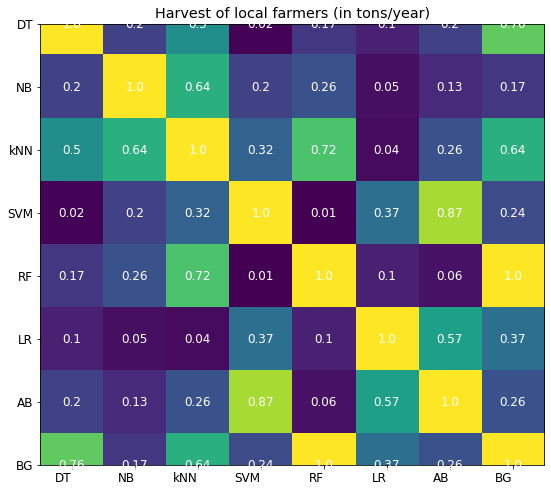

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

veg = ["DT", "NB", "kNN", "SVM", "RF", "LR", "AB", "BG"]
far = ["DT", "NB", "kNN", "SVM", "RF", "LR", "AB", "BG"]
#farmers = ["Adult", "Credit", "Absent", "Derma", "Wine", "Network", "Bank", "Optic", "Diabet", "Heart"]


#tclose
har = np.array([[1, 0.2,0.5, 0.02, 0.17, 0.1, 0.2, 0.76   ],
                   [ 0.2, 1, 0.64, 0.2, 0.26, 0.05, 0.13, 0.17   ],
                   [ 0.5, 0.64, 1, 0.32, 0.72, 0.04,0.26, 0.64  ],
                   [ 0.02, 0.2,0.32, 1, 0.01, 0.37, 0.87, 0.24  ],
                   [ 0.17, 0.26,0.72, 0.01, 1, 0.1,0.06, 1  ],
                   [ 0.1, 0.05, 0.04, 0.37, 0.1, 1, 0.57, 0.37  ],
                   [ 0.2, 0.13, 0.26, 0.87, 0.06, 0.57, 1, 0.26  ],
                   [ 0.76, 0.17, 0.64, 0.24,1, 0.37,0.26,1 ] ])

 
#ldiverse
#harvest = np.array([[1,   0.006  , 0.021, 0.507,  0.113,  0.005, 0.006, 0.005],
 #                  [0.006, 1    , 0.168, 0.012,  0.006, 0.721, 0.241, 0.006],
  #                 [0.021, 0.168 ,  1, 0.028, 0.036, 0.006,  0.139, 0.028],
   #                [0.507, 0.012, 0.028,  1, 0.575, 0.006,  0.006, 0.878],
    #              [0.113, 0.006,  0.036, 0.006, 1, 0.005, 0.009, 0.138],
     #             [0.005, 0.721, 0.006 , 0.575,  0.005,  1, 0.005, 0.005],
      #             [0.006, 0.241, 0.139, 0.006, 0.009, 0.005, 1,  0.009],
       #           [0.005, 0.006,  0.028,   0.878,  0.138, 0.005,  0.009, 1]])

#kanonym    
#harvest = np.array([[ 1, 0.2, 0.2, 0.95, 0.005, 0.016, 0.059, 0.005],
#                    [0.2, 1, 0.44, 0.24, 0.64, 0.44, 0.87, 0.5],
 #                  [ 0.2, 0.44, 1, 0.11, 0.79, 0.005, 0.2, 0.64 ],
  #                 [0.95, 0.24, 0.11, 1, 0.38, 0.005, 0.012, 0.64],
 #                  [ 0.005, 0.64, 0.79, 0.38, 1, 0.11, 0.5, 0.012 ],
  #                 [ 0.016, 0.44, 0.005, 0.005, 0.11, 1, 0.13, 0.074],
  #                  [ 0.059, 0.87, 0.2, 0.012, 0.5, 0.13, 1, 0.28 ],
   #                [ 0.005, 0.5, 0.64, 0.64, 0.012, 0.074, 0.28, 1] ])
    

#harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
 #                   [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
  ##                 [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
    #                [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
     #               [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
      #              [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])


fig, ax = plt.subplots()
im = ax.imshow(har)
# We want to show all ticks...
ax.set_xticks(np.arange(len(far)))
ax.set_yticks(np.arange(len(veg)))
# ... and label them with the respective list entries
ax.set_xticklabels(far)
ax.set_yticklabels(veg)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(),  ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(veg)):
    for j in range(len(far)):
        text = ax.text(j, i, har[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
#plt.show()


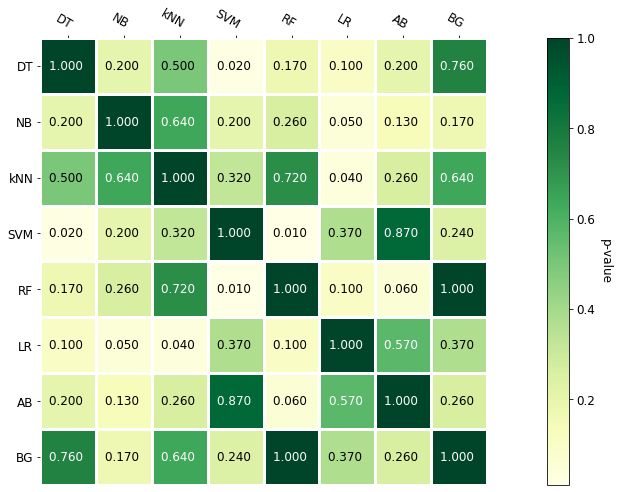

In [12]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,7)

im, cbar = heatmap(har, veg, far, ax=ax,
                   cmap="YlGn", cbarlabel="p-value")
texts = annotate_heatmap(im, valfmt="{x:.3f} ")

fig.tight_layout()
plt.show()
fig = ax.get_figure()


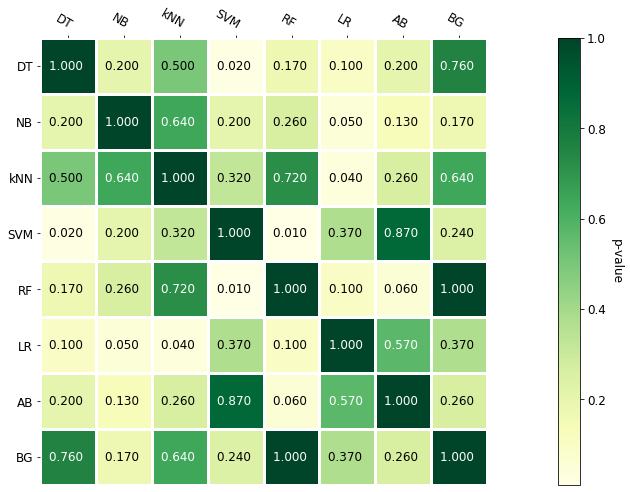

In [13]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,15)

im, cbar = heatmap(har, veg, far, ax=ax,
                   cmap="YlGn", cbarlabel="p-value")
texts = annotate_heatmap(im, valfmt="{x:.3f} ")

fig.tight_layout()
plt.show()
fig = ax.get_figure()


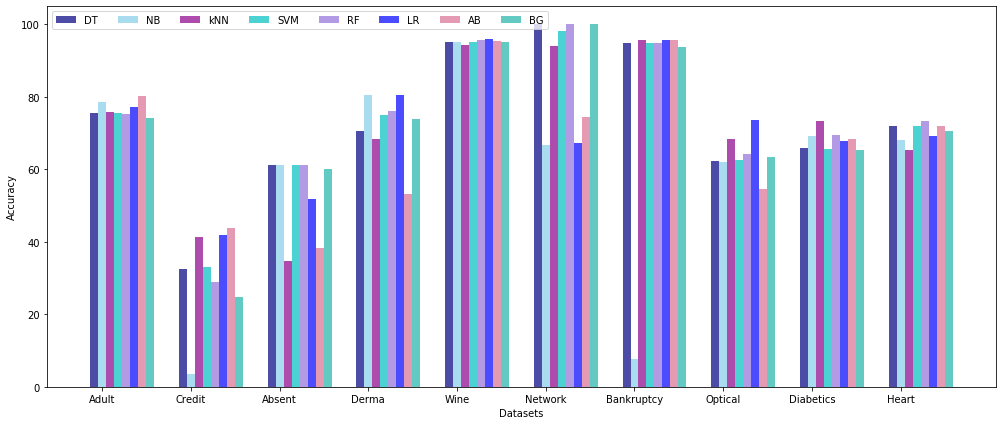

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (17,7)
#plt.style.use('ggplot')
n = 10
DT= (75.47, 32.54,  61.08, 70.65, 95.2, 100.0, 94.88,  62.34, 65.97,  72.0 )                                                
NB= (78.52, 3.55, 61.08, 80.43, 95.02, 66.79,  7.8,  62.03, 69.1,  68.0)
kNN = (75.78,  41.42, 34.59, 68.48,  94.28, 93.96, 95.56, 68.41, 73.26, 65.33)
SVM = (75.47, 33.14, 61.08, 75.0,  95.08, 98.11, 94.88, 62.66, 65.62, 72.0)
RF= (75.26, 28.99, 61.08, 76.09, 95.63, 100.0, 94.76, 64.23, 69.44, 73.33)
LR = (77.23, 42.01, 51.89, 80.43, 96.0,  67.17, 95.67, 73.64, 67.71, 69.33)
AB = (80.35, 43.79,  38.38, 53.26, 95.45, 74.34, 95.56,  54.6, 68.4, 72.0)
BG = (74.27, 24.85, 60.0 , 73.91, 95.14, 100.0, 93.68, 63.39, 65.28, 70.67) 



fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.09
opacity = 0.7
ax.bar(index, DT, bar_width, alpha=opacity, color='navy', label='DT')
ax.bar(index+bar_width, NB, bar_width, alpha=opacity, color='skyblue', label='NB')
ax.bar(index+2*bar_width, kNN, bar_width, alpha=opacity,  color='darkmagenta', label='kNN')
ax.bar(index+3*bar_width, SVM, bar_width, alpha=opacity, color='c', label='SVM')
ax.bar(index+ 4*bar_width, RF, bar_width, alpha=opacity, color='mediumpurple', label='RF')
ax.bar(index+5*bar_width, LR, bar_width, alpha=opacity, color='b', label='LR')
ax.bar(index+6*bar_width, AB, bar_width, alpha=opacity, color='palevioletred', label='AB')
ax.bar(index+7*bar_width, BG, bar_width, alpha=opacity,color='lightseagreen', label='BG')


ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
#ax.set_title('The Accuracy of Different Classifiers over 2-diverse Datasets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('Adult','Credit','Absent','Derma','Wine', 'Network', 'Bankruptcy', 'Optical', 'Diabetics', 'Heart'))
ax.legend(ncol=8)
plt.show()

#fig = ax.get_figure()
#fig.savefig('C:/Users/20184069/Desktop/popets/image/3anonymity22.pdf')

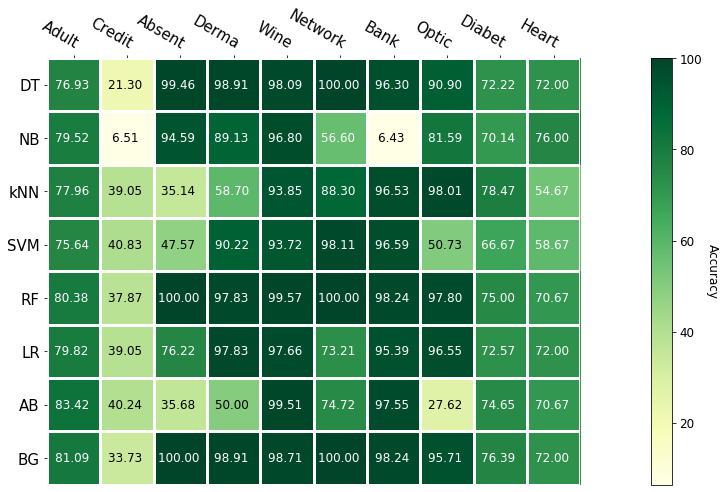

In [56]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,7)
plt.rcParams.update({'font.size': 12})

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f} ")

fig.tight_layout()
plt.show()

fig = ax.get_figure()
fig.savefig('C:/Users/20184069/Desktop/popets/image/heatAccuracyoriginal2.pdf')

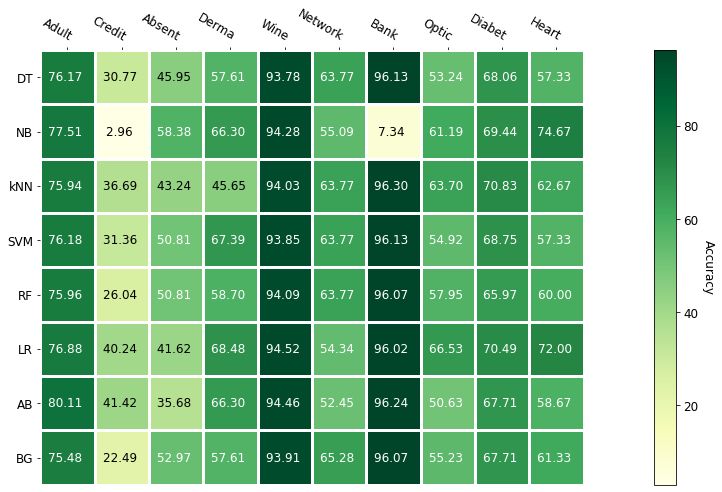

In [65]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,7)
plt.rcParams.update({'font.size': 12})

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f} ")

fig.tight_layout()
plt.show()

fig = ax.get_figure()
fig.savefig('C:/Users/20184069/Desktop/popets/image/heatldiverse.pdf')

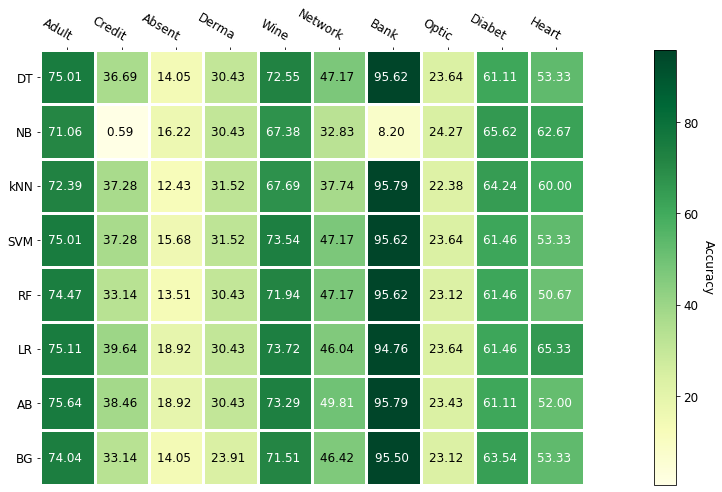

In [73]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (20,7)

plt.rcParams.update({'font.size': 12})
im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="Accuracy")
texts = annotate_heatmap(im, valfmt="{x:.2f} ")

fig.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig('C:/Users/20184069/Desktop/popets/image/heatclose.pdf')

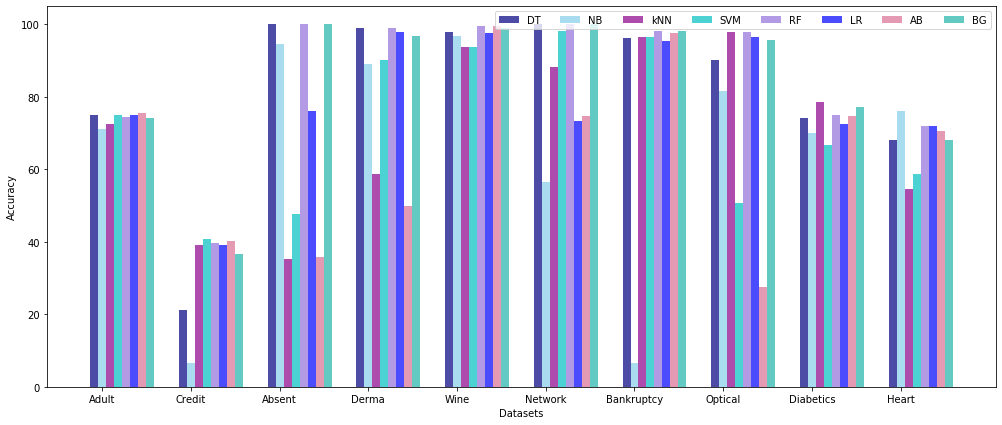

In [899]:

#Original 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (17,7)
#plt.style.use('ggplot')
n = 10
DT = (75.01, 21.3, 100.0, 98.91,  97.97,  100.0, 96.3, 90.17,  74.31,  68.0 )                                     
NB = (71.06, 6.51, 94.59, 89.13,  96.8, 56.6, 6.43, 81.59, 70.14, 76.0)
kNN= (72.39, 39.05,  35.14, 58.7, 93.85, 88.3,  96.53, 98.01, 78.47, 54.67)
SVM=(75.01,  40.83, 47.57,  90.22, 93.72, 98.11,  96.59, 50.73, 66.67, 58.67 )
RF = (74.49, 39.64,  100.0,  98.91, 99.57, 100.0, 98.24, 97.91, 75.0, 72.0)
LR =( 75.11, 39.05, 76.22, 97.83,  97.66,  73.21, 95.39, 96.55, 72.57, 72.0 )
AB =(75.64, 40.24, 35.68, 50.0, 99.51, 74.72, 97.55,  27.62, 74.65, 70.67)
BG =( 74.13, 36.69,  100.0,   96.74,  99.14, 100,  98.29, 95.82 , 77.08, 68.0) 



fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.09
opacity = 0.7
ax.bar(index, DT, bar_width, alpha=opacity, color='navy', label='DT')
ax.bar(index+bar_width, NB, bar_width, alpha=opacity, color='skyblue', label='NB')
ax.bar(index+2*bar_width, kNN, bar_width, alpha=opacity,  color='darkmagenta', label='kNN')
ax.bar(index+3*bar_width, SVM, bar_width, alpha=opacity, color='c', label='SVM')
ax.bar(index+ 4*bar_width, RF, bar_width, alpha=opacity, color='mediumpurple', label='RF')
ax.bar(index+5*bar_width, LR, bar_width, alpha=opacity, color='b', label='LR')
ax.bar(index+6*bar_width, AB, bar_width, alpha=opacity, color='palevioletred', label='AB')
ax.bar(index+7*bar_width, BG, bar_width, alpha=opacity,color='lightseagreen', label='BG')


ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
#ax.set_title('The Accuracy of Different Classifiers over 2-diverse Datasets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('Adult','Credit','Absent','Derma','Wine', 'Network', 'Bankruptcy', 'Optical', 'Diabetics', 'Heart'))
ax.legend(ncol=8)
plt.show()

#fig = ax.get_figure()
#fig.savefig('C:/Users/20184069/Desktop/popets/image/oroginal.pdf')

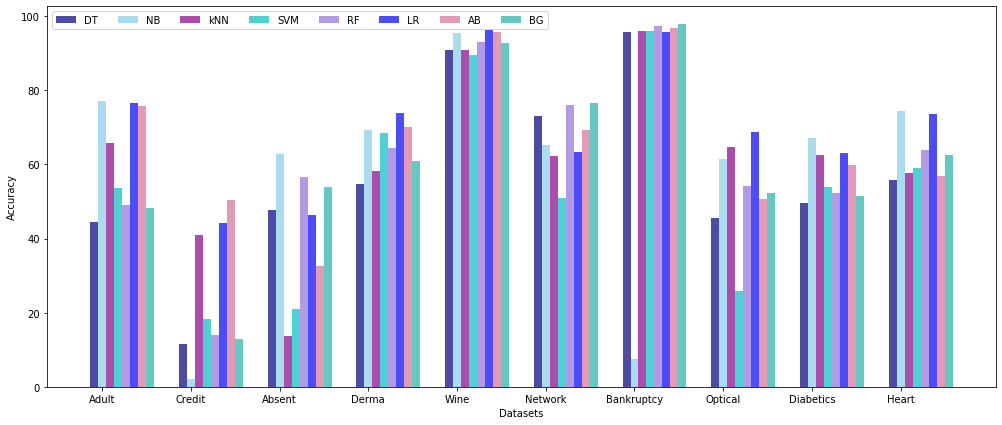

In [907]:
#k-anonymity 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (17,7)
#plt.style.use('ggplot')
n = 10

DT = (44.35, 11.62, 47.57, 54.69, 90.93, 73.11,  95.6,  45.45, 49.64, 55.65)                                                                   
NB = (77.01, 1.98, 62.67, 69.35, 95.51, 65.28, 7.39, 61.42,  67.02, 74.26)
kNN = (65.63, 40.9, 13.8, 58.32, 90.73, 62.26, 96.04, 64.57, 62.51, 57.54)
SVM= (53.55, 18.21, 20.95, 68.4, 89.55, 50.94, 96.0, 25.95, 53.8, 58.92)
RF = (48.95, 14.02, 56.52, 64.37, 92.94, 75.94, 97.45, 54.06, 52.33, 63.97)
LR = (76.53, 44.14, 46.42, 73.81, 96.28, 63.21, 95.79, 68.75, 63.02, 73.58)
AB= (75.77, 50.39, 32.7, 70.08, 95.8, 69.34, 96.83, 50.68, 59.9, 56.98)
BG= (48.35, 12.91,  54.0,  60.88, 92.74, 76.42,  97.75, 52.26, 51.47,  62.63)  


fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.09
opacity = 0.7
ax.bar(index, DT, bar_width, alpha=opacity, color='navy', label='DT')
ax.bar(index+bar_width, NB, bar_width, alpha=opacity, color='skyblue', label='NB')
ax.bar(index+2*bar_width, kNN, bar_width, alpha=opacity,  color='darkmagenta', label='kNN')
ax.bar(index+3*bar_width, SVM, bar_width, alpha=opacity, color='c', label='SVM')
ax.bar(index+ 4*bar_width, RF, bar_width, alpha=opacity, color='mediumpurple', label='RF')
ax.bar(index+5*bar_width, LR, bar_width, alpha=opacity, color='b', label='LR')
ax.bar(index+6*bar_width, AB, bar_width, alpha=opacity, color='palevioletred', label='AB')
ax.bar(index+7*bar_width, BG, bar_width, alpha=opacity,color='lightseagreen', label='BG')


ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
#ax.set_title('The Accuracy of Different Classifiers over 2-diverse Datasets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('Adult','Credit','Absent','Derma','Wine', 'Network', 'Bankruptcy', 'Optical', 'Diabetics', 'Heart'))
ax.legend(ncol=8)
plt.show()

#fig = ax.get_figure()
#fig.savefig('C:/Users/20184069/Desktop/popets/image/crosskanonym.pdf')

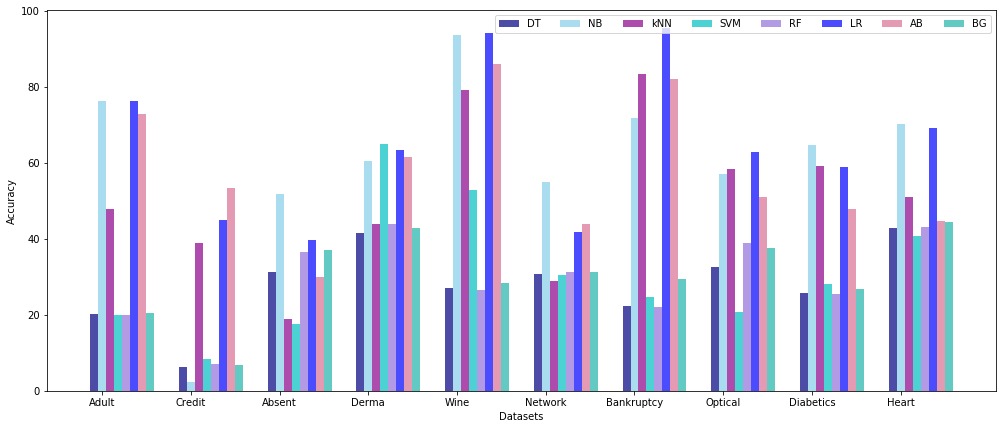

In [908]:
#l-diversity 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (17,7)
#plt.style.use('ggplot')
n = 10
DT=(20.15, 6.28,  31.3, 41.65, 27.13, 30.85, 22.22, 32.65, 25.8, 42.79)                                                                                 
NB = (76.36, 2.4, 51.88,  60.45, 93.79, 54.91, 71.77,  56.96, 64.77,  70.21)
kNN= (47.75, 38.84, 18.8, 43.92, 79.14, 28.87,  83.5, 58.43, 59.12, 51.11)
SVM= (20.05, 8.39, 17.51, 65.11, 52.8, 30.38, 24.57, 20.69, 28.22, 40.82)
RF = (20.09, 7.15, 36.48, 44.04, 26.66, 31.32, 21.99,  38.9, 25.45, 43.14)
LR= (76.25, 44.9, 39.65, 63.28, 94.33, 41.7, 95.43, 62.96, 58.87, 69.23)
AB =(72.99, 53.37, 30.03, 61.67, 86.09, 43.87, 81.99, 50.99, 47.84, 44.79)
BG =(20.47, 6.82,  37.04, 42.97,  28.37, 31.32, 29.54, 37.65, 26.92, 44.47)  



fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.09
opacity = 0.7
ax.bar(index, DT, bar_width, alpha=opacity, color='navy', label='DT')
ax.bar(index+bar_width, NB, bar_width, alpha=opacity, color='skyblue', label='NB')
ax.bar(index+2*bar_width, kNN, bar_width, alpha=opacity,  color='darkmagenta', label='kNN')
ax.bar(index+3*bar_width, SVM, bar_width, alpha=opacity, color='c', label='SVM')
ax.bar(index+ 4*bar_width, RF, bar_width, alpha=opacity, color='mediumpurple', label='RF')
ax.bar(index+5*bar_width, LR, bar_width, alpha=opacity, color='b', label='LR')
ax.bar(index+6*bar_width, AB, bar_width, alpha=opacity, color='palevioletred', label='AB')
ax.bar(index+7*bar_width, BG, bar_width, alpha=opacity,color='lightseagreen', label='BG')


ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
#ax.set_title('The Accuracy of Different Classifiers over 2-diverse Datasets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('Adult','Credit','Absent','Derma','Wine', 'Network', 'Bankruptcy', 'Optical', 'Diabetics', 'Heart'))
ax.legend(ncol=8)
plt.show()

#fig = ax.get_figure()
#fig.savefig('C:/Users/20184069/Desktop/popets/image/crossldiverse.pdf')

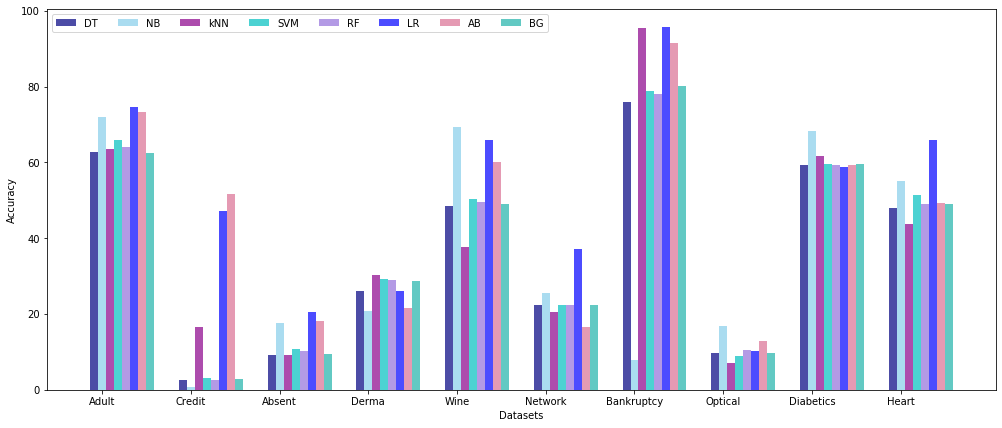

In [909]:
# t-closeness

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (17,7)
#plt.style.use('ggplot')
n = 10

DT=(62.88, 2.52,  9.16, 26.18, 48.46, 22.45, 76.1,  9.73, 59.35, 48.08)                                                             
NB= (72.04, 0.67, 17.76, 20.89, 69.28,  25.57, 7.86,  16.95, 68.38, 55.13)
kNN =(63.68,  16.45, 9.14, 30.18, 37.57, 20.66, 95.5, 7.09, 61.7, 43.83)
SVM=(65.85, 3.18, 10.69, 29.22, 50.39, 22.45, 78.98, 9.04, 59.52,  51.44)
RF= (64.06, 2.59, 10.3, 28.96, 49.48, 22.45, 78.04, 10.43, 59.44, 49.06)
LR=(74.58, 47.32, 20.58, 26.18, 65.97, 37.26, 95.66, 10.22, 58.83, 65.85)
AB=(73.44, 51.74, 18.29, 21.62, 60.09, 16.6,  91.51,  12.82, 59.44, 49.4)
BG=(62.59, 2.86, 9.37, 28.67, 49.0, 22.45, 80.18, 9.8, 59.61,  49.06)


fig, ax = plt.subplots()
index = np.arange(n)
bar_width = 0.09
opacity = 0.7
ax.bar(index, DT, bar_width, alpha=opacity, color='navy', label='DT')
ax.bar(index+bar_width, NB, bar_width, alpha=opacity, color='skyblue', label='NB')
ax.bar(index+2*bar_width, kNN, bar_width, alpha=opacity,  color='darkmagenta', label='kNN')
ax.bar(index+3*bar_width, SVM, bar_width, alpha=opacity, color='c', label='SVM')
ax.bar(index+ 4*bar_width, RF, bar_width, alpha=opacity, color='mediumpurple', label='RF')
ax.bar(index+5*bar_width, LR, bar_width, alpha=opacity, color='b', label='LR')
ax.bar(index+6*bar_width, AB, bar_width, alpha=opacity, color='palevioletred', label='AB')
ax.bar(index+7*bar_width, BG, bar_width, alpha=opacity,color='lightseagreen', label='BG')


ax.set_xlabel('Datasets')
ax.set_ylabel('Accuracy')
#ax.set_title('The Accuracy of Different Classifiers over 2-diverse Datasets')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(('Adult','Credit','Absent','Derma','Wine', 'Network', 'Bankruptcy', 'Optical', 'Diabetics', 'Heart'))
ax.legend(ncol=8)
plt.show()

#fig = ax.get_figure()
#fig.savefig('C:/Users/20184069/Desktop/popets/image/crosstclose.pdf')

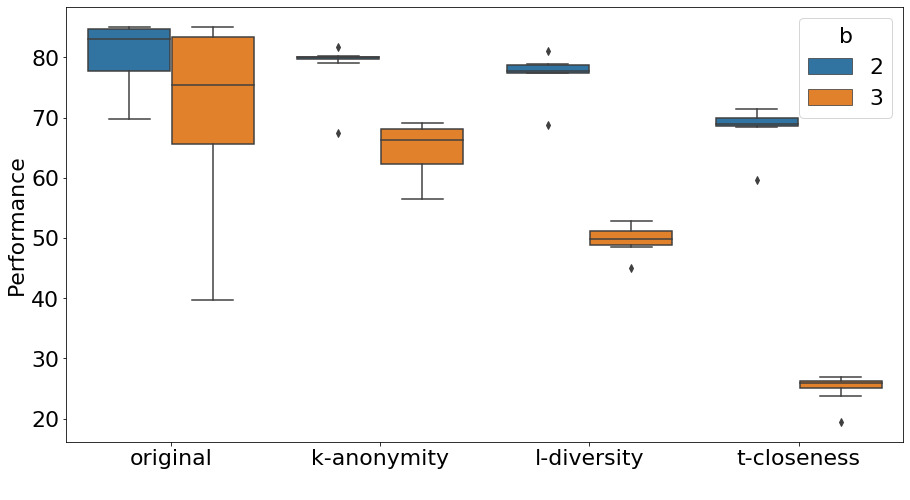

In [41]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (15, 8)
plt.rcParams.update({'font.size': 22})

df = pd.DataFrame(
[
[83.11, 79.96 , 77.338  , 68.71 , 2],
[69.70, 67.40,  68.726, 59.71, 2],
[ 79, 80.04, 78.91, 70.89, 2 ],
[ 74.11, 79.87 , 77.51, 68.86, 2 ],
[ 84.62, 80.20, 77.67, 68.44 , 2 ],
 [ 83.04, 80.05, 81.07, 71.49, 2 ],
[ 84.92, 81.68, 78.80, 69.60, 2 ],    
[ 85.04, 79.03, 77.67, 69.02, 2 ],
[ 82.98, 67.93, 49.34, 26.10, 3 ],
[76.592 , 58.60 , 50.45 , 19.44, 3 ],
[61.454 ,63.45 , 48.47 , 23.77 , 3 ],
[67.12 , 68.56, 52.81, 26.1, 3 ],
[85.11 , 69.04 , 50.89, 25.73, 3 ],
[74.22 , 64.72 , 52.04, 26.93, 3 ],
[39.76 , 56.46 , 44.97, 26.76, 3 ],
[ 84.71, 67.91 , 48.91 , 25.62, 3 ]
], columns=['original', 'k-anonymity', 'l-diversity', 't-closeness', 'b'])

df_long = pd.melt(df, "b", var_name=" ", value_name="Performance")
sns.boxplot(x=" ", hue="b", y="Performance", data=df_long)



